$\text{Name: Marcelo Augusto Ferreira dos Santos}$

$$\text{Statistical Physics project - IFT/Unesp, 2021}$$

$$ \textbf{Metropolis Algorithm For 2D Ising Model}$$

We will use the Metropolis Algorithm, as described in section 7.2 of [1], to study the Ising model in a square lattice. A square lattice of side lenght $L$ will have $N = L^2$ spins, and $2^{L^2}$ different microstates. The number of microstates scales exponentially with the size of the system, so computing thermodynamical quantities by averaging over the full space of microstates (with weight given by the Boltzmann-Gibbs distribution) is very time consuming, even for small values of $L$, since this entails visiting every microstate available. To get around this, the Metropolis Algorithm chooses instead to visit only a fraction of the space of available states. Specifically, the algorithm performs a random walk in the space of states $\sigma$, where the probability transition rate is given by the Metropolis $\textit{detailed balance}$ condition:

\begin{align} W(\nu \to \sigma) & = 1 \quad \text{if } E_{\sigma} \leq E_{\nu} \\ W(\nu \to \sigma) & = \frac{P_{\sigma}}{P_{\nu}} = e^{-\beta (E_{\sigma} - E_{\nu})} \quad \text{if } E_{\sigma} > E_{\nu} \end{align}

The algorithm, and its difference to the usual Monte Carlo procedure, can be summarized succintly: "instead of choosing configurations randomly, then weighting them with exp(−E/kT), we choose configurations with a probability exp(−E/kT) and weight them evenly"[2][3].

We do our numerical simulation using Python. First, we import the relevant libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

The Hamiltonian describing the system is

\begin{equation} H = - J \sum\limits_{< ij > = 1} S_i S_j - h \sum\limits_i S_i \end{equation}

where $J$ is the interaction strength and $h$ is the external field strength. $<ij> = 1$ when the i-th and j-th spins are closest neighbors. We use $\text{periodic boundary conditions}$. 

The zero field ($ h = 0$) 2d Ising Model exibits a ferromagnectic phase transition, in contrast with the 1d Ising Model, which does not. This can be shown by a heuristic argument, due to Peirls, which argues in terms of the thermal stability of the ferromanegnectic configuration for low temperatures. One can estimate the net change in free energy $F = E - TS$ which is caused by the introduction of a spin defect in a ordered configuration. According to the principles of thermodynamics, if the variation of free energy of such a change is negative, then this change will happen espontaneously and the ordered state will hence be unstable. 

For a 1d chain of $N$ spins, a defect consists of flipping a cluster of spins in an intially ordered chain (all spins up, for instance). The change in energy due to the flip is $2J$, and the change in entropy is $S_f - S_i = k_B \ln N$, since we have $N$ places where we can put the defect. The change in free energy is thus negative for large $N$, $\Delta F = 2J - k_B T \ln N$, and hence the ordered state is unstable. For 2d lattice, on the other hand, a defect is a bubble of flipped spins. If the bubble has perimeter $b$, the total change in energy caused by the defect is $2Jb$. The change in entropy is $\Delta S = k_B \ln \nu(b)$, where $\nu(b)$ is the number of ways we can place the defect. The top left spin of the bubble can be anyone out of $N$, and starting from this site, the bubble can be constructed in $b-1$ choices, each with $3$ or minus options. This follows because $3^{b-1}$ is the number of paths that we can perform on a square lattice choosing from three directions at each step (backward steps are forbidden). Hence $\nu(b) \leq N 3^{b-1}$, and thus

\begin{equation} \Delta F \approx 2Jb - k_B T \left( \ln N/3 + b \ln 3 \right) \end{equation}

The change is only thermodynamically favoured when $\Delta F < 0$. If $T \gtrapprox \frac{2J}{k_B \ln 3 }$, the bubbles are always favoured and the system thus prefers a disordened state. For $T \lessapprox \frac{2J}{k_B \ln 3 }$, only some bubbles are favoured. Specifically, in this case $\Delta F < 0$ only if

\begin{equation} b \lessapprox \frac{ k_B T \ln N/3} {2J - k_B T \ln 3} \end{equation}

Thus only bubbles with number of spins $\sim (\ln N)^2$ will appear spontaneously. The fraction of spins in the down state will thus scale as $\frac{(\ln N)^2}{N} \to 0$. Hence, in the thermodynamical limit, the ordered state is favoured.

We want to check this phase transition numerically. We shall set $k_B = 1$ and compute our quantities at $h = 0$. We define now the function which will perform the Metropolis sweep. It has as argument a configuration of the lattice. It chooses a random spin, flips it, and computes the change in the energy $\Delta E$ which the spin flip causes. Then a random number is drawn from the interval $[0,1]$, and the new configuration is kept if the condition

\begin{equation} r \leq e^{-\beta \Delta E} \end{equation}

is satisfied. Note that if $\Delta E < 0$, the new configuration is always kept. But there is also a change of keeping the new configuration if $\Delta E \geq 0$, so the algorithm can also visit states far from the ground state. 

The function metropolis does not choose a spin randomly, but rather visits all of the spins of the lattice in order. I choose to do this because I found that it converged faster than the alternative. In each spin, it does a flip, computes the change in energy and then keeps the change according to the criterium of the last equation. After all of the spins have been visited, we say that a sweep has been performed. 

When the spin $S_i$ is flipped, the change in energy is

\begin{aligned} \Delta E = 2 J \sum\limits_{j; <ij> = 1} S_i S_j = 2 J S_i \sum\limits_{j; <ij> = 1} S_j \end{aligned}

In [7]:
def metropolis(grid, T):
    
    J = 1 # interaction strength (Joules)
    k = 1 # we set Boltzmann constant to 1
    
    L = len(grid)
    
    for a in range(L):
        for b in range(L):
        
            # deltaE = 2*J* \sum_{neighbors of k} S_k S_i = 2*J*S_k \sum_{neighbors of k} S_i
            # we use periodic boundary conditions
        
            sum_of_neighbors = grid[(a+1)%L,b] + grid[a,(b+1)%L] + grid[(a-1)%L,b] + grid[a,(b-1)%L]
            deltaE = 2*J*grid[a,b]*sum_of_neighbors
        
            # decide if we flip the spin of the chosen site
            
            if deltaE < 0:
                grid[a,b] *= -1

            elif np.exp(-deltaE/(k*T)) > np.random.rand():
                grid[a,b] *= -1
        
    return grid

We also define two functions which we use to compute the total energy and magnetization of the lattice.

In [8]:
# magnetization
def mag(grid):
    return np.sum(grid)

# energy
def energy(grid):
    
    J = 1
    
    total_energy = 0
    
    L = len(grid)
    
    for i in range(L):
        for j in range(L):
            sum_of_neighbors = grid[(i+1)%L,j] + grid[i,(j+1)%L] + grid[(i-1)%L,j] + grid[i,(j-1)%L]
            total_energy += -J*grid[i,j]*sum_of_neighbors
    
    # we summed each term 4 times, so we have to divide by 4
    return (1/4)*total_energy

Now we introduce the parameters of the numerical simulation. We take $80$ points of temperature, from $T = 1.5 J$ to $T = 3 J$. We choose such a small interval of temperature values to obtain a more precise value for the critical temperature. We perform $5000$ sweeps until termalization. After that, we perform $1000$ cycles of $10$ sweeps, taking measurements at the end of each cycle. To make the program run faster, these parameters can be changed. With these choices, to program takes a few hours to run completely.

We will do the simulation for the sizes $L = 30, 40, 50, 60$.

In [9]:
# parameters

N_points = 80 # number of temperature points
N_eq = 5*10**3 # number of iterations until equilibrium
N_av = 10**3 # iterations of metropolis to compute average

T_max = 3 # max of temperature
T_min = 1.5 # min of temperature

The initial configuration of the lattice, which is chosen randomly, will probably be far away from equilibrium, in the sense that its Boltzmann weight is very small[1]. Before we can start computing thermodynamical quantities, we must first run a number of thermalization sweeps, until the configurations generated have the appropriate weight. We can compute the time correlation function of a thermodynamical quantity $A$. If $A_n$ is the quantity computed on the lattice after $n$ sweeps, we compute

\begin{equation} C(n) = \frac{ \left\langle A_n A_0 \right\rangle - \left\langle A_n \right\rangle \left\langle A_0 \right\rangle }{\left\langle A_0^2 \right\rangle - \left\langle A_0 \right\rangle^2}\end{equation}

This is normalized such that $C(0) = 1$. We want the configuration to "forget" about its initial state. This happens when $C \approx 0$[1]. Generally, $C(n) \sim e^{-n/n_0}$, where $n_0$ is the relaxation time in units of sweeps.[1] We want to perform a number of iterations $N_{eq} >> n_0$. We will compute $n_0$, and see if $C$ approaches $0$ for $20$ sweeps, for $L = 40$ and $T = 2$. We choose the magnetization as our quantity. With this choice,

\begin{equation} C(n) = \frac{ \left\langle S^{(n)} S^{(0)} \right\rangle - \left\langle S^{(n)} \right\rangle \left\langle S^{(0)} \right\rangle }{ \left\langle S^{(0)} S^{(0)} \right\rangle - \left\langle S^{(0)} \right\rangle^2 } \end{equation}

We approximate the various quantities by statistics of our sample, more specifically we compute averages with the lattice mean, for instance $ \left\langle S^{(n)} \right\rangle \approx \sum_i \frac{1}{N} S^{(n)}_i$. Hence

\begin{equation} C(n) \approx \frac{ N \sum_i S^{(n)}_i S^{(0)}_i -  \sum_i S^{(n)}_i \sum_j S^{(0)}_j }{ N \sum_i S^{(0)}_i S^{(0)}_i -  \sum_i S^{(0)}_i \sum_j S^{(0)}_j  } \end{equation}

Text(0, 0.5, 'Time correlation function')

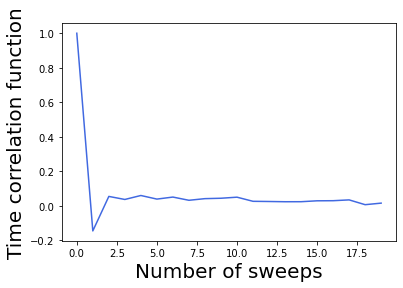

In [7]:
L = 60
T = 2

grid = 2*(np.random.rand(L, L) > 0.5) - 1 # random initial lattice with values of +1 and -1

time_cov = np.zeros(20)

grid0 = grid.copy()
varM0 = L**2*np.sum(np.multiply(grid0, grid0)) - (np.sum(grid0))**2

for i in range(20):
    time_cov[i] = (L**2*np.sum(np.multiply(grid0, grid)) - (np.sum(grid0))*(np.sum(grid))) / varM0 
    grid = metropolis(grid, T)

plt.plot(time_cov, color='RoyalBlue')
plt.xlabel("Number of sweeps", fontsize=20)
plt.ylabel("Time correlation function", fontsize=20)

It is clear that the time correlation function goes to zero very quickly. This is a necessary condition for our thermalization. But it is not suficient, so we let the system evolve for a longer time. It is interesting to keep track of the time correlation function by number of spin flips, instead of sweeps, since the behavior is smoother in this case. But we don't do that. We can see that, clearly, $n_0$ is of the order of magnitude of a few sweeps. Our choice is hundreds of times greater than $n_0$, $N_{eq} = 5000$.

Now we proceed to compute our thermodynamical quantities. We do this for the four values of $L$ previously cited. Apart from the energy and magnetization per particle, we also compute the thermal capacity and susceptibility per particle.

After the $N_{av}$ sweep cycles have been performed, we will have computed $M^{(1)}, M^{(2)}, \dots, M^{(N_{av})}$ values of the magnetization of the grid. The estimation of the thermal magnetization is

\begin{equation} \left\langle M \right\rangle = \frac{1}{N_{av}} \sum\limits_{k = 1}^{N_{av}} M^{(k)} \end{equation}

The magnetic suscepitibily is given by

\begin{equation} \chi = \frac{\partial \left\langle M \right\rangle}{\partial h} = \partial_h \sum_{\sigma} \frac{e^{-\beta E_{\sigma}}}{z} M^{\sigma}  = \beta \sum \frac{e^{-\beta E_{\sigma}}}{z} M^{\sigma  2} - \beta \left( \sum \frac{e^{-\beta E_{\sigma}}}{z} M^{\sigma}\right)^2 = \beta \left( \left\langle M^2 \right\rangle - \left\langle M \right\rangle^2 \right) \end{equation}

The Metropolis estimate is thus

\begin{equation} \chi = \frac{1}{T} \left( \frac{1}{N_{av}} \sum\limits_{k = 1}^{N_{av}} M^{(k)2} - \left( \frac{1}{N_{av}} \sum\limits_{k = 1}^{N_{av}} M^{(k)} \right)^2 \right)\end{equation}

Accordingly, the energy and thermal capacity estimated by

\begin{equation} \left\langle E \right\rangle = \frac{1}{N_{av}} \sum\limits_{k = 1}^{N_{av}} E^{(k)}\end{equation}

\begin{equation} C = \frac{1}{T^2} \left( \frac{1}{N_{av}} \sum\limits_{k = 1}^{N_{av}} E^{(k)2} - \left( \frac{1}{N_{av}} \sum\limits_{k = 1}^{N_{av}} E^{(k)} \right)^2 \right)\end{equation}

we normalize all of these quantities by the number of particles $N$, obtaining $m = \left\langle M \right\rangle/N$, $u = \left\langle E \right\rangle/N$, $c = C/N$ and $\chi/N$.

We now implement the main part of the project. We first use $L = 60$.

In [10]:
# L = 60

L = 60

T_list = np.linspace(T_min, T_max, N_points)

u60 = np.zeros(N_points) # energy for various values of temperature
m60 = np.zeros(N_points) # magnetization for various values of temperature
c60 = np.zeros(N_points) # thermal capacity for various values of temperature
chi60 = np.zeros(N_points) # susceptibility for various values of temperature
    
# OBS: these quantities will be computed per particle
    
for i in range(N_points):
        
    T = T_list[i]
    
    # random initial state
    grid = 2*(np.random.rand(L, L) > 0.45) - 1
    
    # iteration until thermalization
    for ite in range(N_eq):
        grid = metropolis(grid, T)
        
    # thermodynamical quantities
    E1 = 0 # < E >
    E2 = 0 # < E^2 >
        
    M1 = 0 # < M >
    M2 = 0 # < M^2 >
        
    for ite in range(N_av):
        E = energy(grid)
        E1 += E/N_av
        E2 += E**2/N_av
            
        M = mag(grid)
        M1 += M/N_av
        M2 += M**2/N_av
        
        grid = metropolis(grid, T)
    
    # we divide by N = L^2
    
    u60[i] = E1/L**2
    m60[i] = np.abs(M1)/L**2
    c60[i] = (1/T**2)*(E2 - (E1)**2)/L**2
    chi60[i] = (1/T)*(M2 - (M1)**2)/L**2

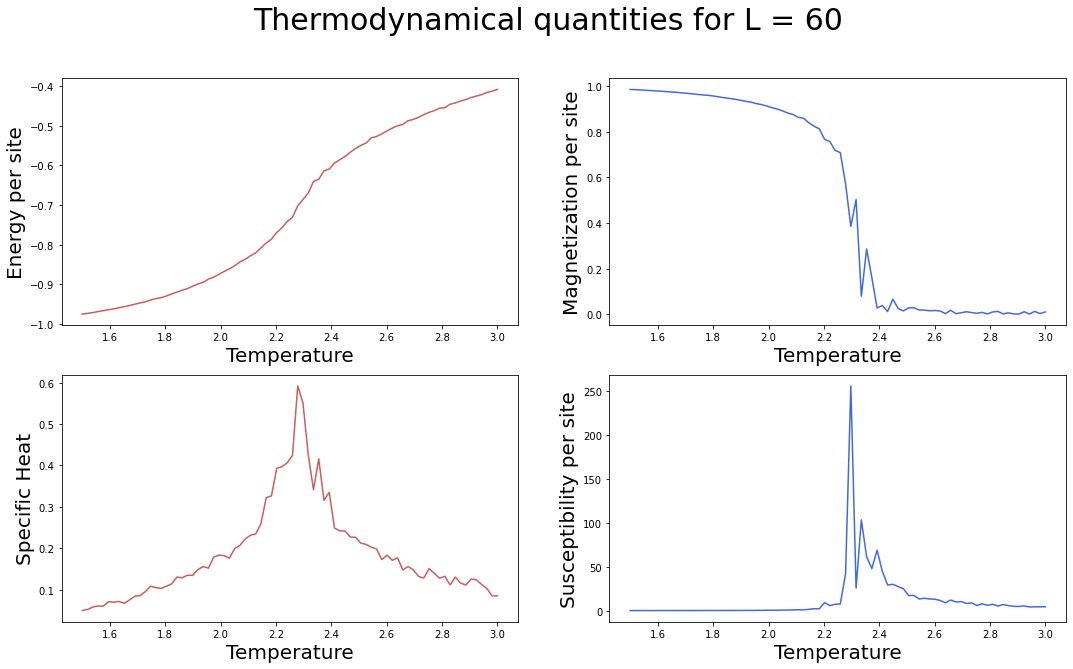

In [11]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    
f.suptitle("Thermodynamical quantities for L = 60", fontsize = 30)

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T_list, u60, color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Energy per site", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T_list, np.abs(m60), color='RoyalBlue')
plt.xlabel("Temperature", fontsize=20); 
plt.ylabel("Magnetization per site", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T_list, c60, color='IndianRed')
plt.xlabel("Temperature", fontsize=20);  
plt.ylabel("Specific Heat", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T_list, chi60, color='RoyalBlue')
plt.xlabel("Temperature", fontsize=20); 
plt.ylabel("Susceptibility per site", fontsize=20);   plt.axis('tight');

The behavior is as expected. The Ising Model in 2d has a phase transition at a critical temperature $T_c$. For temperatures below $T_c$, the system magnetizes spontaneously, and the state is globally ordered: the system is ferromagnetic. Above $T_c$, there is no spontaneous ferromagnetism. 

The suceptibility and the specific heat are both small far away from the critical temperature, and peak at around the critical temperature. For $N = \infty$, there is an actual divergence at these points. In our finite grid, there is a point of maximum, which allow us to estimate the critical temperature.

The phase transition can be determined by finding the temperature at which the magnetization vanishes, or, equivalently, by finding the divergence (for a finite grid, the maximum) of the susceptibility. Visually, we determine $T_c$ to be $= 2.3 \pm 0.1$, in units of $J/k_B$. This agrees with the analytical Onsager solution


\begin{equation} \frac{k_B T_c}{J} = \frac{2}{\ln(1 + \sqrt{2})} \approx 2.269 \end{equation}

We could also plot the magnetization and susceptibily per temperature for other values of $J$. But, since this part of the code only depends on the ratio $T/J$, this would simply amount to a reescaling of the obtained results, giving us the same estimate of the critical temperature in units of $J/k_B$.

We now do the same numerical work for other values of $L$.

In [10]:
# OTHER VALUES OF L

##############################################################################
# L = 30

L = 30

T_list = np.linspace(T_min, T_max, N_points)

u30 = np.zeros(N_points) # energy for various values of temperature
m30 = np.zeros(N_points) # magnetization for various values of temperature
c30 = np.zeros(N_points) # thermal capacity for various values of temperature
chi30 = np.zeros(N_points) # susceptibility for various values of temperature
    
# OBS: these quantities will be computed per particle

for i in range(N_points):
        
    T = T_list[i]
    
    # random initial state
    grid = 2*(np.random.rand(L, L) > 0.45) - 1
    
    # iteration until thermalization
    for ite in range(N_eq):
        grid = metropolis(grid, T)
        
    # thermodynamical quantities
    E1 = 0 # < E >
    E2 = 0 # < E^2 >
        
    M1 = 0 # < M >
    M2 = 0 # < M^2 >
        
    for ite in range(N_av):
        E = energy(grid)
        E1 += E/N_av
        E2 += E**2/N_av
            
        M = mag(grid)
        M1 += M/N_av
        M2 += M**2/N_av
        
        grid = metropolis(grid, T)
    
    # we divide by N = L^2
    
    u30[i] = E1/L**2
    m30[i] = np.abs(M1)/L**2
    c30[i] = (1/T**2)*(E2 - (E1)**2)/L**2
    chi30[i] = (1/T)*(M2 - (M1)**2)/L**2
    
##############################################################################
# L = 40

L = 40

T_list = np.linspace(T_min, T_max, N_points)

u40 = np.zeros(N_points) # energy for various values of temperature
m40 = np.zeros(N_points) # magnetization for various values of temperature
c40 = np.zeros(N_points) # thermal capacity for various values of temperature
chi40 = np.zeros(N_points) # susceptibility for various values of temperature
    
# OBS: these quantities will be computed per particle

for i in range(N_points):
        
    T = T_list[i]
    
    # random initial state
    grid = 2*(np.random.rand(L, L) > 0.45) - 1
    
    # iteration until thermalization
    for ite in range(N_eq):
        grid = metropolis(grid, T)
        
    # thermodynamical quantities
    E1 = 0 # < E >
    E2 = 0 # < E^2 >
        
    M1 = 0 # < M >
    M2 = 0 # < M^2 >
        
    for ite in range(N_av):
        E = energy(grid)
        E1 += E/N_av
        E2 += E**2/N_av
            
        M = mag(grid)
        M1 += M/N_av
        M2 += M**2/N_av
        
        grid = metropolis(grid, T)
    
    # we divide by N = L^2
    
    u40[i] = E1/L**2
    m40[i] = np.abs(M1)/L**2
    c40[i] = (1/T**2)*(E2 - (E1)**2)/L**2
    chi40[i] = (1/T)*(M2 - (M1)**2)/L**2

##############################################################################
# L = 50

L = 50

T_list = np.linspace(T_min, T_max, N_points)

u50 = np.zeros(N_points) # energy for various values of temperature
m50 = np.zeros(N_points) # magnetization for various values of temperature
c50 = np.zeros(N_points) # thermal capacity for various values of temperature
chi50 = np.zeros(N_points) # susceptibility for various values of temperature
    
# OBS: these quantities will be computed per particle

for i in range(N_points):
        
    T = T_list[i]
    
    # random initial state
    grid = 2*(np.random.rand(L, L) > 0.45) - 1
    
    # iteration until thermalization
    for ite in range(N_eq):
        grid = metropolis(grid, T)
        
    # thermodynamical quantities
    E1 = 0 # < E >
    E2 = 0 # < E^2 >
        
    M1 = 0 # < M >
    M2 = 0 # < M^2 >
        
    for ite in range(N_av):
        E = energy(grid)
        E1 += E/N_av
        E2 += E**2/N_av
            
        M = mag(grid)
        M1 += M/N_av
        M2 += M**2/N_av
        
        grid = metropolis(grid, T)
    
    # we divide by N = L^2
    
    u50[i] = E1/L**2
    m50[i] = np.abs(M1)/L**2
    c50[i] = (1/T**2)*(E2 - (E1)**2)/L**2
    chi50[i] = (1/T)*(M2 - (M1)**2)/L**2

We plot the susceptibility for all values of $L$.

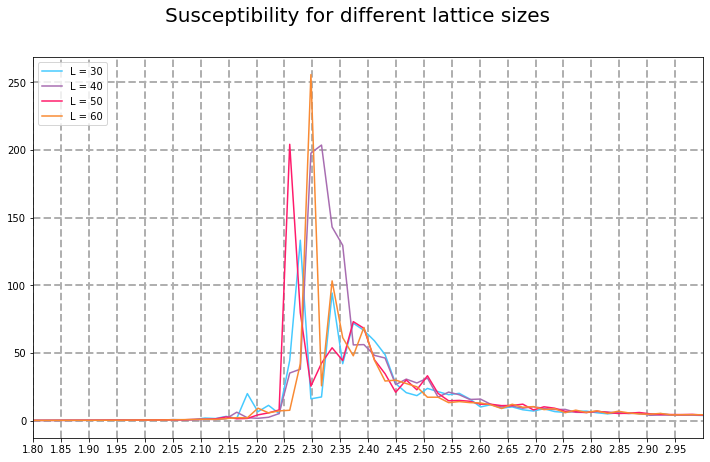

In [12]:
f = plt.figure(figsize=(12, 7)); # plot the calculated values    
f.suptitle("Susceptibility for different lattice sizes", fontsize = 20)

sp =  f.add_subplot(1, 1, 1 );
plt.plot(T_list, chi30, '#45CAFF', label = 'L = 30')
plt.plot(T_list, chi40, '#A86DB1',label = 'L = 40')
plt.plot(T_list, chi50, '#FF1B6B',label = 'L = 50')
plt.plot(T_list, chi60, '#F98A33',label = 'L = 60')
plt.legend(loc="upper left")
plt.xlim(1.8, 3)
plt.xticks(np.arange(1.8, 3, 0.05))
plt.grid(linestyle='--', linewidth=2)

The maximum gets bigger as $L$ grows. In the thermodynamical limit, $L \to \infty$, the maximum becomes a divergence. We define as $T_c(L)$ the point at which the susceptibility is maximal. This will have an uncertainty due to our discretization of temperature, and also a uncertainty due to the approximate nature of our calculation. We estimate, visually

\begin{equation} T_c(L) = 2.28, 2.32, 2.26, 2.30 \text{ for } L = 30, 40, 50, 60\end{equation}

We disregard the uncertainties (since this is a very rough estimative). The result could be better if we had performed more iterations or did the computation for more temperature points. 

The finite-scalling theory as presented in section 7.6 of [1] predicts the two following relations

\begin{equation} T_c(L) = T_c + (x_0 T_c) L^{-1/\nu} \end{equation}

\begin{equation} \chi(T_c(L)) \sim y_0 L^{\gamma/\nu} \end{equation}

where $\nu$ and $\gamma$ are the critical exponents of the correlation length and of the susceptibility, respectively, and $x_0$ and $y_0$ are constants. The analytical values are $\nu = 1$ and $\gamma = 1.75$. We can plot $T_c(L)$ against $1/L$ to estimate $T_c$ (supposing $\nu = 1$), and also $\ln \chi(T_c(L))$ against $\ln L$ to estimate $\gamma/\nu$. 

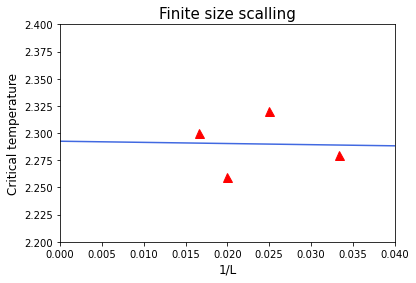

In [24]:
T_c = np.array([2.28, 2.32, 2.26, 2.3])
L = np.array([30, 40, 50, 60])

plt.plot(1/L, T_c, marker='^', linestyle = '',
     color='Red', markersize=9)

## linear fit, T_c = a * (1/L) + b
x = np.linspace(0, 0.04, 5)
a, b = np.polyfit(1/L, T_c, 1)
plt.plot(x, a*x + b, color = "RoyalBlue")

plt.xlim(0, 0.04)
plt.ylim(2.2,2.4)

plt.xlabel('1/L', fontsize = 12)
plt.ylabel('Critical temperature', fontsize = 12)

plt.title('Finite size scalling', fontsize = 15);

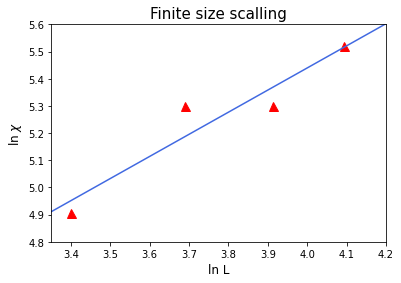

In [28]:
lnchi = np.log(np.array([135, 200, 200, 250]))
lnL = np.log(np.array([30, 40, 50, 60]))

plt.plot(lnL, lnchi, marker='^', linestyle = '',
     color='Red', markersize=9)

## linear fit, ln \chi(T_c) = a2 * (ln L) + b2
x = np.linspace(3.35, 4.2, 5)
a2, b2 = np.polyfit(lnL, lnchi, 1)
plt.plot(x, a2*x + b2, color = "RoyalBlue")

plt.xlim(3.35, 4.2)
plt.ylim(4.8,5.6)

plt.xlabel('ln L', fontsize = 12)
plt.ylabel('ln $\chi$', fontsize = 12)

plt.title('Finite size scalling', fontsize = 15);

A regressão linear nos fornece as estimativas:

In [29]:
print("T_c = %f" %b)
print("gamma/nu = %f" %a2)

T_c = 2.292511
gamma/nu = 0.813850


The uncertainty of $T_c$ is of the order of magnitude of our discretization of temperature values, 0.01 in units of $J/k_B$. We obtained the good estimative

$$T_c = 2.29 \pm 0.01 \frac{J}{k_B} $$

This agrees with the analytical result in two uncertainties. The result could be better if we did more sweeps in the simulation or used more values of $L$.

For $\gamma/\nu$, what we obtained does not agree with the analytical result. We obtained 

$$ \gamma/\nu \sim 0.8 $$

while the exact value is $1.75$. We suspect that this disagreement could be corrected if we used more sweeps. We can store our results for later use:

In [30]:
%store T_list u60 u50 u40 u30 m60 m50 m40 m30 c60 c50 c40 c30 chi60 chi50 chi40 chi30;

UsageError: Unknown variable 'T_list'


In [5]:
%store -r T_list u60 u50 u40 u30 m60 m50 m40 m30 c60 c50 c40 c30 chi60 chi50 chi40 chi30

$\textbf{Conclusion}$

Our simple code gave us a good estimative for the critical temperature of the 2D Ising model, and also gave us the correct qualitative behaviour for the thermodynamical quantities that we plotted. The Metropolis Algorithm, in this version, is a simple tool which makes possible the study of some systems which are difficult to treat analytically. The results of the finite size scalling analysis were not good. Improvement can be made by considering more values of $L$ and by implementing more sweeps in the simulation.

$\textbf{References}$

[1] Michel Le Bellac, Fabrice M. Mortessagne, Ghassan G. Batrouni. Equilibrium And Non-Equilibrium Statistical Thermodynamics. 

[2] Tobin Fricke. Monte Carlo Investigation Of Ising Model. 2006.

[3] Nicholas Metropolis, Arianna W. Rosenbluth, Marshall N. Rosenbluth, Augusta H. Teller, and Edward
Teller. Equation of state calculations by fast computing machines. The Journal of Chemical Physics,
21(6):1087–1092, 1953.

[4] Rajesh Singh. Ising Model. Available in https://rajeshrinet.github.io/blog/2014/ising-model/.

